In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm_notebook

In [2]:
u = 1
chi = 1 / 2
dx = 0.1
dt = (1.01 * (dx ** 2)) / ((dx + 1))

s = u * dt / dx
r = chi * dt / (dx ** 2)

dt

0.010000000000000002

In [3]:
teta = 5
a = 0
b = 10

In [4]:
K = int((b - a) / dx) + 1
K

101

In [5]:
start = np.zeros(K, dtype=np.float64)
for i in range(K // 2):
    start[i] = 1.0

In [6]:
def left_border(t):
    return math.sin(t)

def right_border(t):
    return math.exp(-(t ** 2))

In [7]:
def solve(solver):
    t = 0

    Ts = []
    Ts.append(start)

    while (t < teta):
        t += dt
        cur = solver(t, Ts)
        Ts.append(cur)
    
    return Ts

In [8]:
def evident_opposite(t, Ts):
    cur = np.zeros(K, dtype=np.float64)

    for i in range(K):
        prev_t = Ts[-1][i - 1] if i > 0 else left_border(t)
        next_t = Ts[-1][i + 1] if i < K - 1 else right_border(t)
        cur_t = Ts[-1][i]

        cur[i] = cur_t - s * (cur_t - prev_t) + r * (prev_t + next_t - 2 * cur_t)
    
    return cur

In [9]:
def evident_nonopposite(t, Ts):
    cur = np.zeros(K, dtype=np.float64)

    for i in range(K):
        prev_t = Ts[-1][i - 1] if i > 0 else left_border(t)
        next_t = Ts[-1][i + 1] if i < K - 1 else right_border(t)
        cur_t = Ts[-1][i]

        cur[i] = cur_t - s * (next_t - cur_t) + r * (prev_t + next_t - 2 * cur_t)
    
    return cur

In [10]:
Ts = solve(evident_opposite)

/anaconda3/envs/computational_methods/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


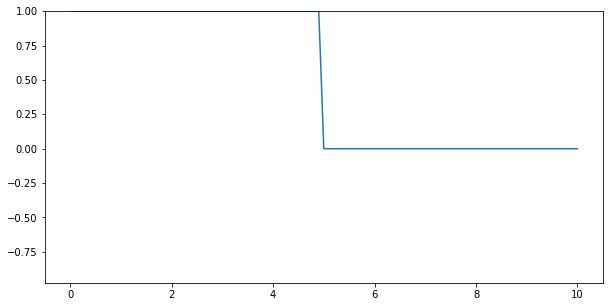

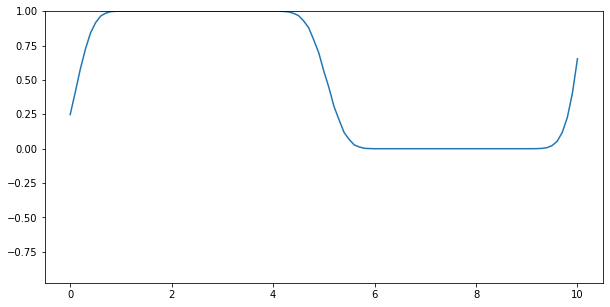

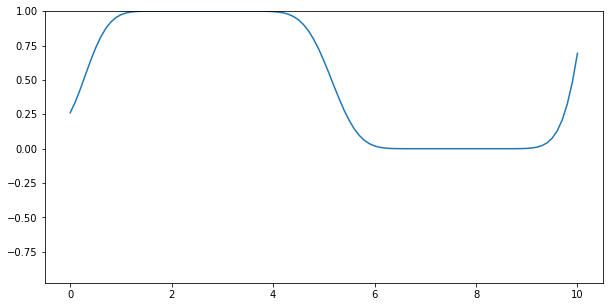

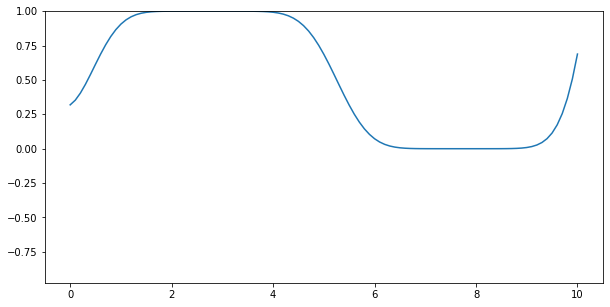

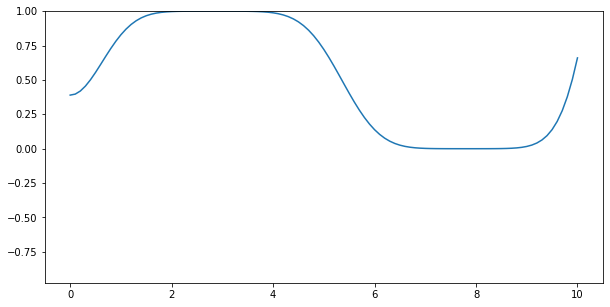

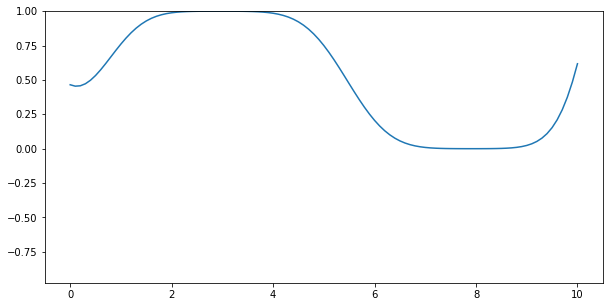

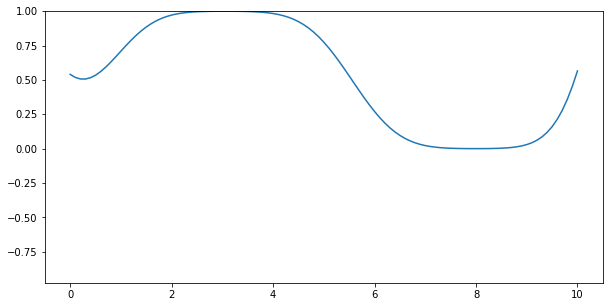

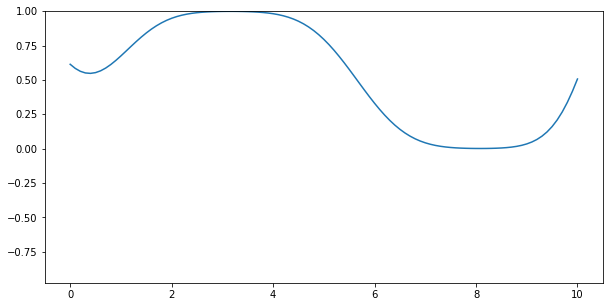

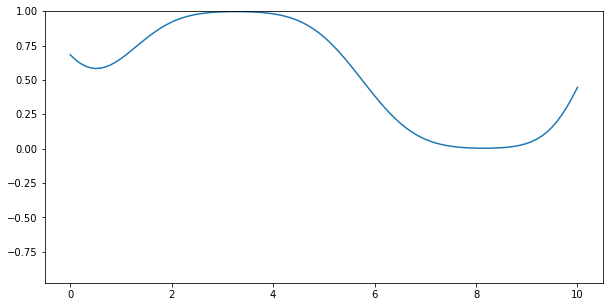

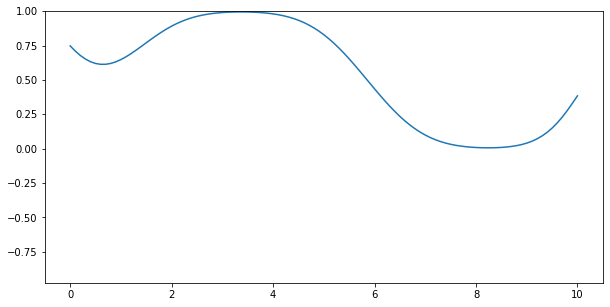

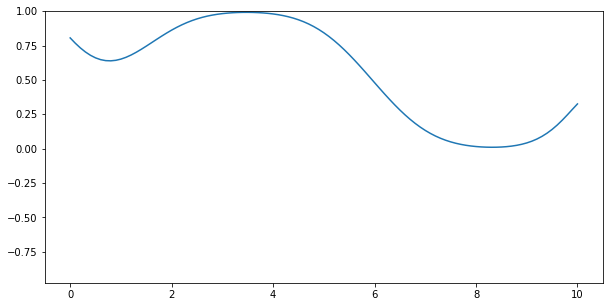

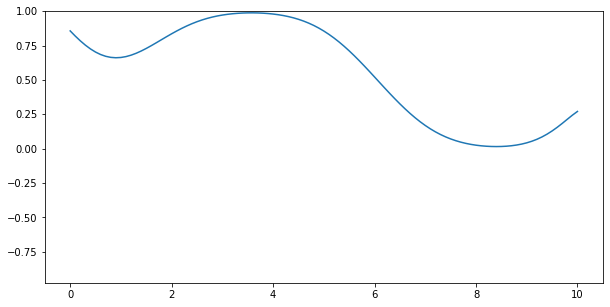

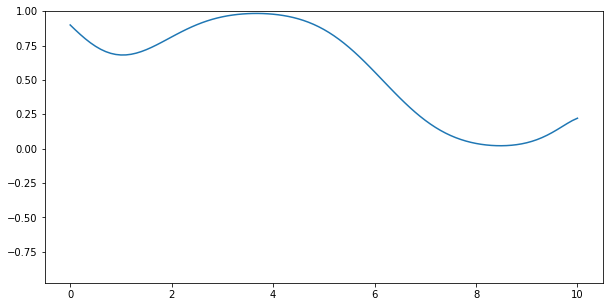

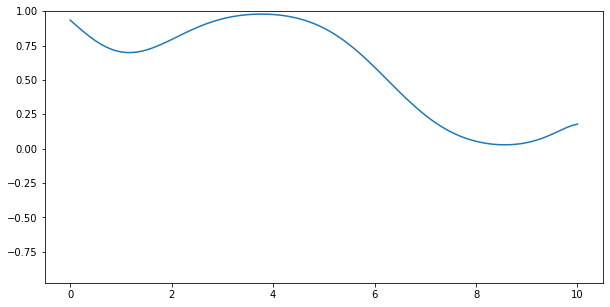

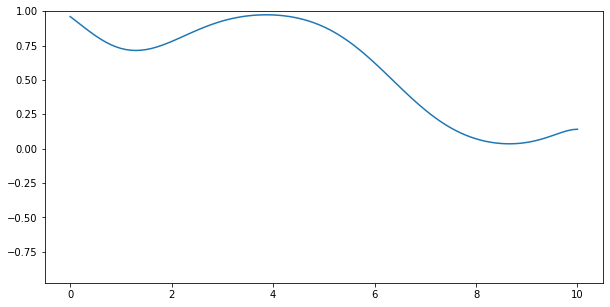

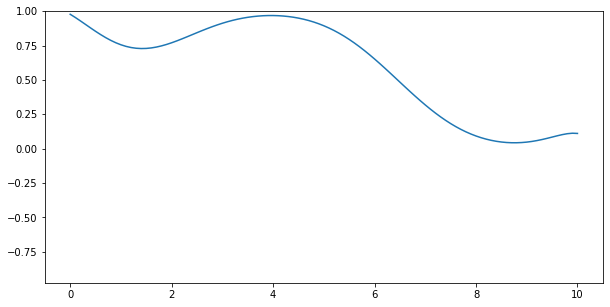

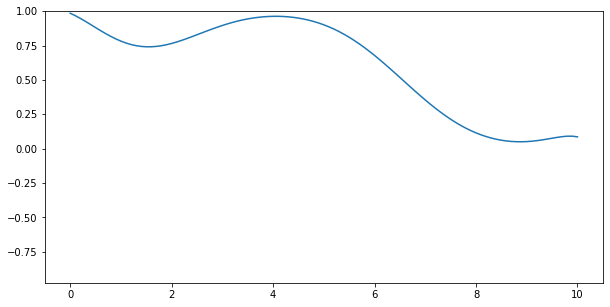

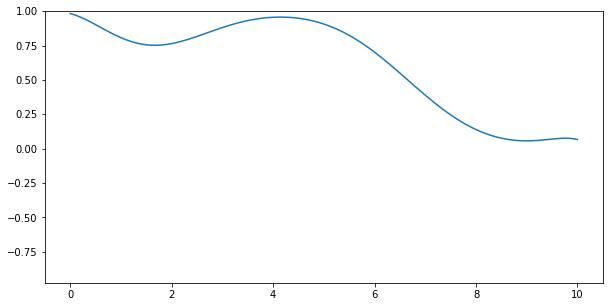

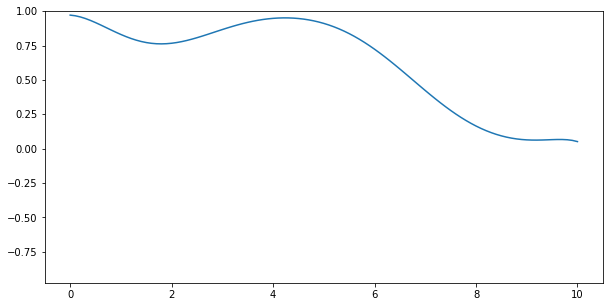

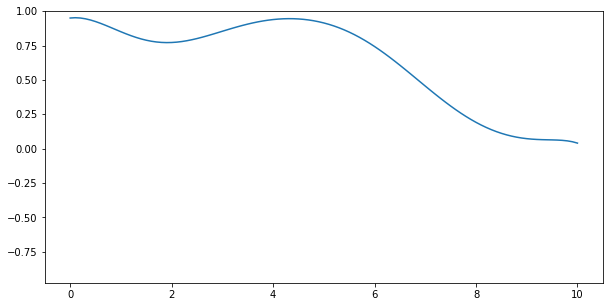

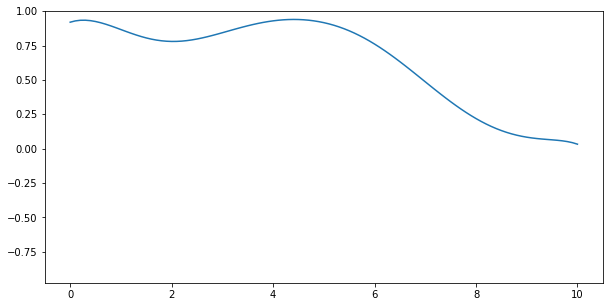

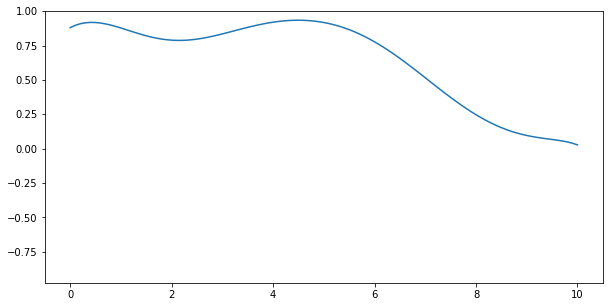

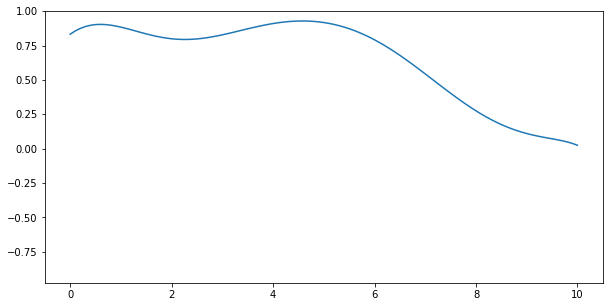

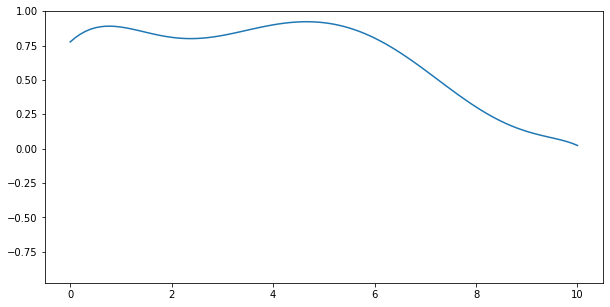

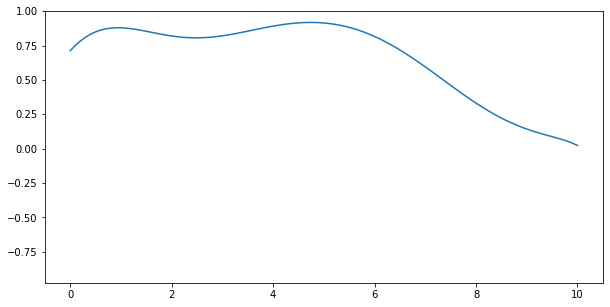

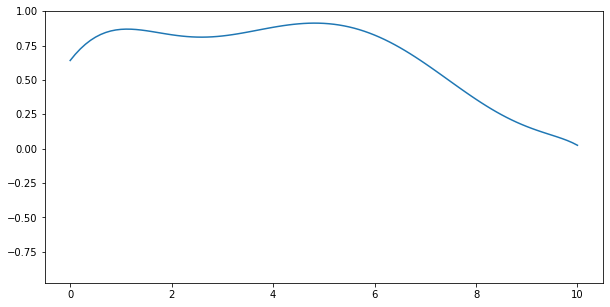

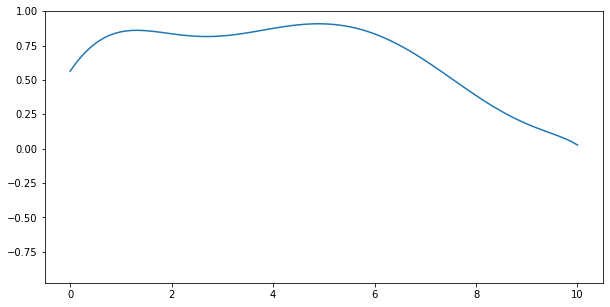

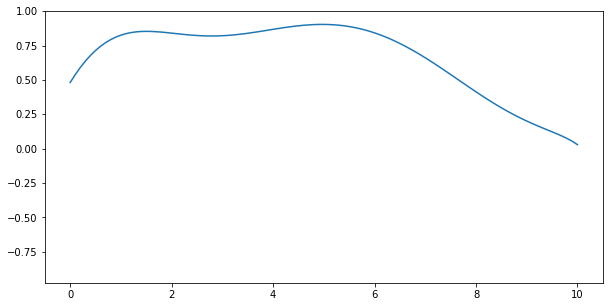

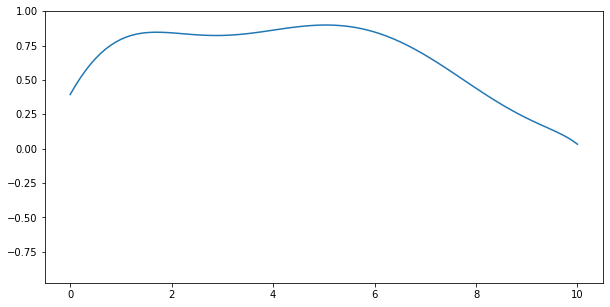

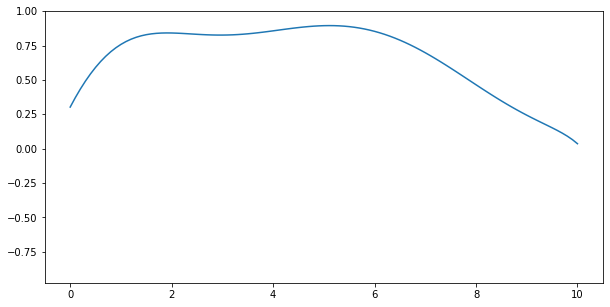

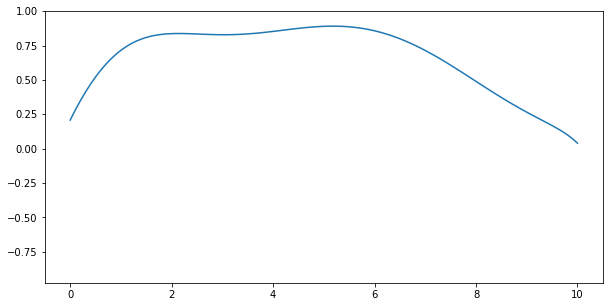

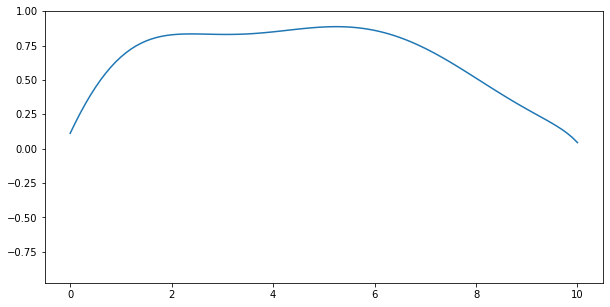

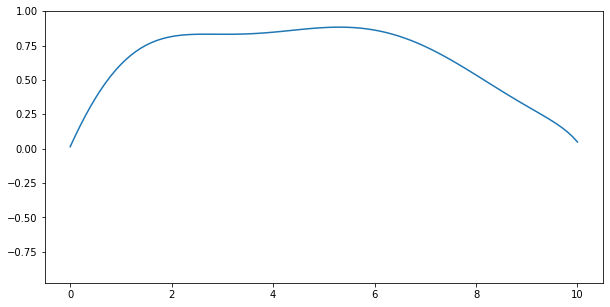

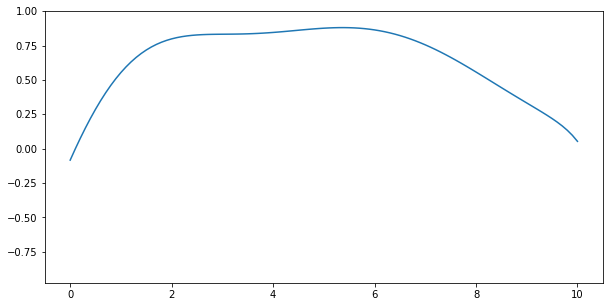

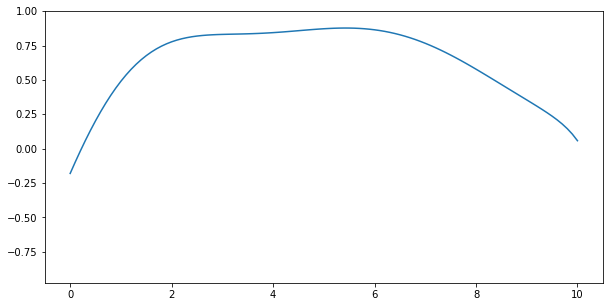

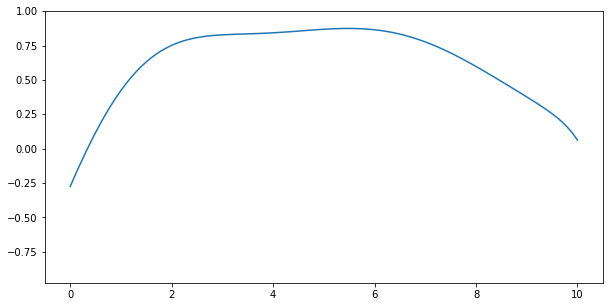

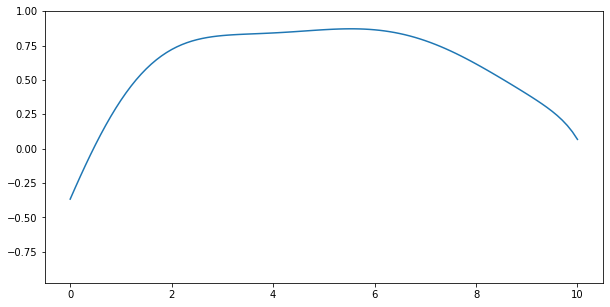

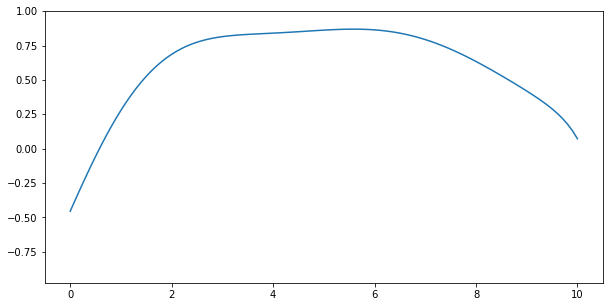

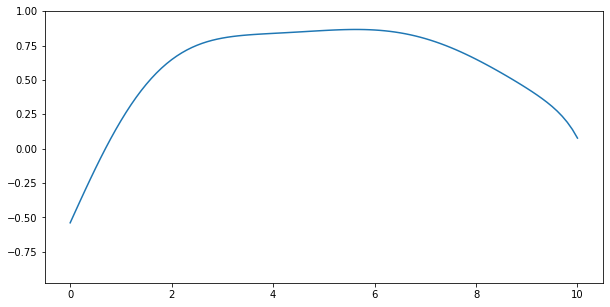

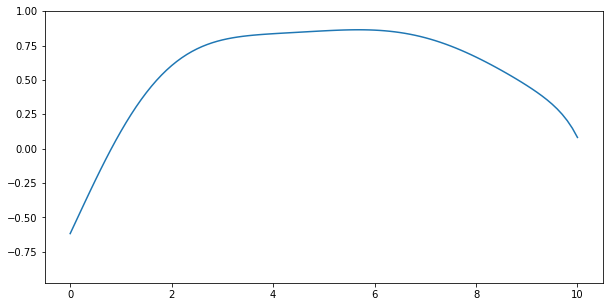

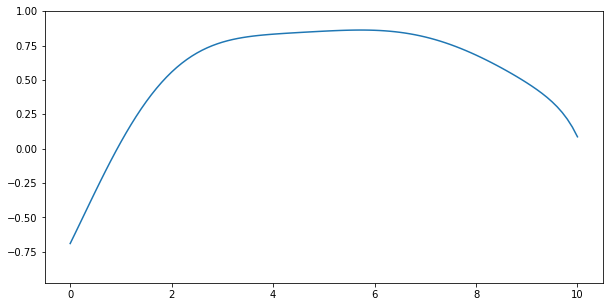

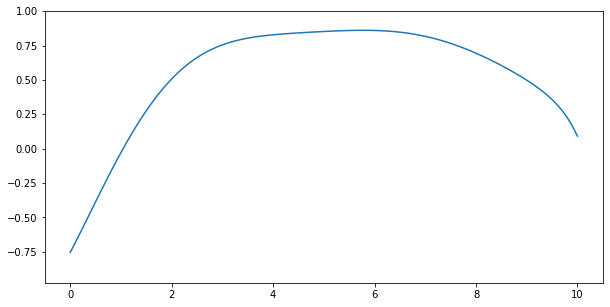

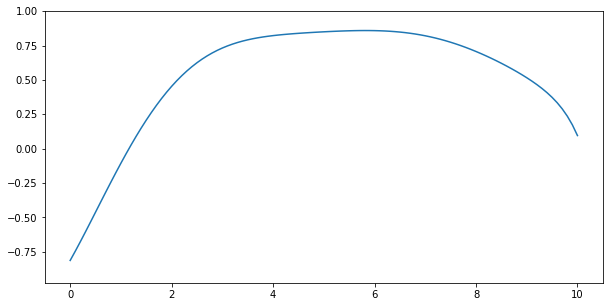

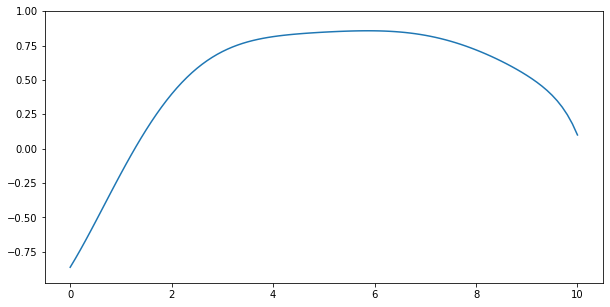

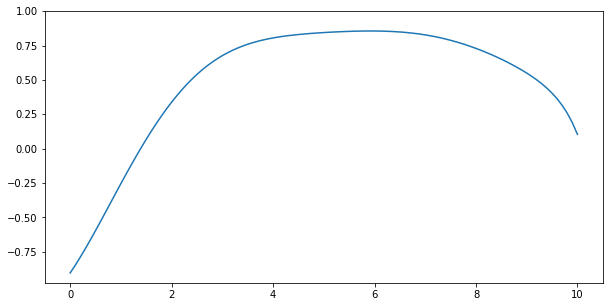

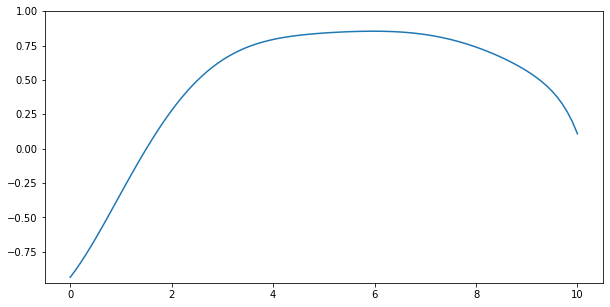

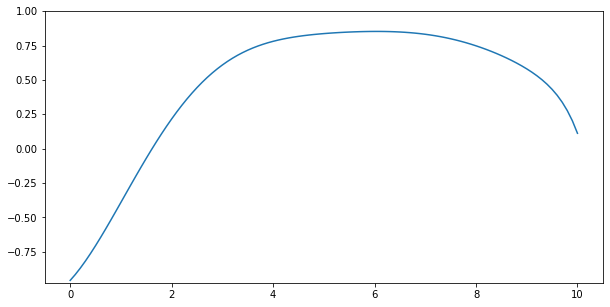

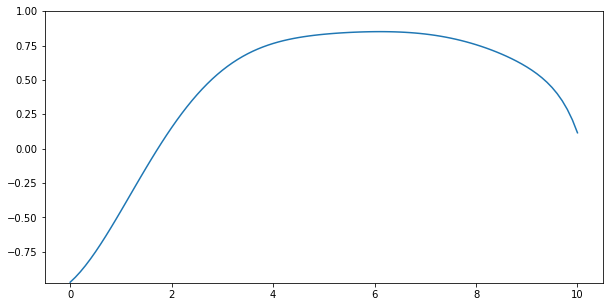

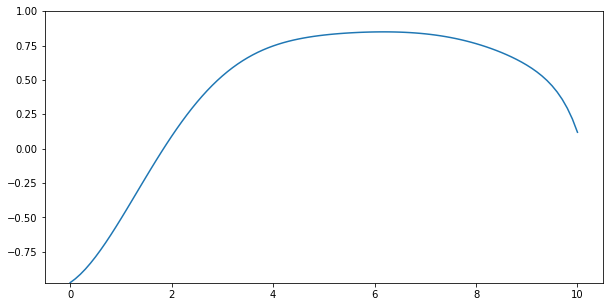

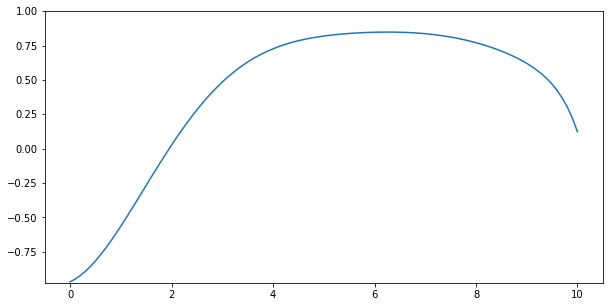

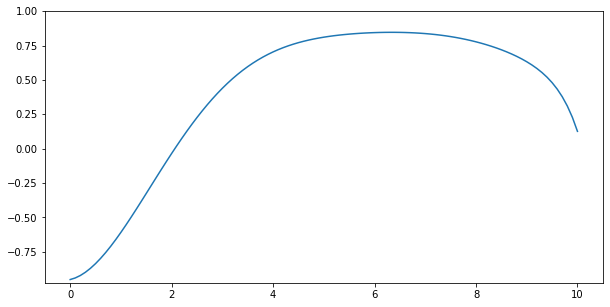

In [11]:
xs = [
    a + i * dx
    for i in range(K)
]

y_min = np.min(np.array(Ts))
y_max = np.max(np.array(Ts))

def plot_img(cur_index):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(xs, Ts[cur_index])

    ax.set_ylim(y_min - 1e-3, y_max + 1e-3)

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

frames = [
    plot_img(i)
    for i in tqdm_notebook(range(len(Ts)))
    if i % 10 == 0
]
imageio.mimsave('./T.gif', frames, fps=10)